### Anomaly Detection
- To indentify the data points that are different of the other data point
- There are 3 categories
    - Supervised Anomaly Dection: labels for both nomal and anomalous data
    - Semi-Supervised Anomaly Dectection: only label of nomal data 
    - Unsupervise Anomaly Dectection: no label is available
- Algorithms
    - Mahalanobis Distance: 
        - For one single dimension data, z-score can be used for outlier/anomaly detection. A data point is labeled as an anomaly if |z| > T (Threshold)
        - For multidimensional data, the z-score is not applicable. The Mahalanobis distance defined as https://en.wikipedia.org/wiki/Mahalanobis_distance
        
    - Density-based spatial clustering of application with noise (DBSCAN)
        - Find neighbors of all points of redius - Redius of defining neighborhood
        - Indentify a core point minimum number of datapoints required for formimng a local cluster
        - Find  the connected components of core point on the neighbors graph
        - Assign each non-core point to a nearby cluster if the cluster is an Redius of defining neighborhood, otherwise assign it to noise
    - Local Outlier Factor (LOF): Density-based anomaly detection algorithm
        - n_neighbors: the factor dictating the neighborhood size
        - contamination: the point of training data that may be outlier or anomalies
        - norlety: True for contrincing decision functin
    - Isolation Forest (iForest)
        - iForest assumes that the normalies are on the edge and should be relately distinguised with the few partition in a binary decision tree (BDT)
        - It is similar to random forest algorithm, iForest contains many isolation tree (iTree) where eacg iTree attemps to partition data points into node until there is only one node left (one data point) or all nodes have the same value.
    - One-Class Support Vector Machine
        - It is an example of a group of classification techniques called One-class Classification (OCC)
        - It tries to identify objects of a specific class amongst all object, by primarily learning from a training set containing only the objects of that class.
        - The term OCC was coined by Moya and Hush in 1996 (https://en.wikipedia.org/wiki/One-class_classification).
        - OOC uses only sample points from the assigned class as a feature. That's why a representative sampling is not strickly required for non-target classes

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# make dataset
from sklearn.datasets import make_blobs

# statistical modules for data generation and critical values
from scipy.stats import multivariate_normal, beta, uniform, t

from functools import partial

from sklearn import svm
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.covariance import EllipticEnvelope # use for Mohalanobis distance
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

from typing import Any


In [2]:
# 3 required parameters
kernel = "rbf"
nu = 0.1
gamma = 1

In [3]:
clf_oneClassSVM = svm.OneClassSVM(kernel = kernel, nu = nu, gamma = gamma)
clf_oneClassSVM

OneClassSVM(gamma=1, nu=0.1)

In [4]:
# create a dataset that have points from a single multivariate Gaussion population, then manuallu add a outlier into a dataset

np.random.seed(0) # random seed = 0
n = 1000 # 1000 samples
mu = np.array([0, 0]) # zero means
sigma = np.array([
    [2, 1],
    [1, 2]
])
normal = multivariate_normal.rvs(mean = mu, cov = sigma, size = n) # rvs: random variates of size (size, N), where N is the dimension of the random variable
normal

array([[-2.44346794, -1.87756019],
       [-2.7832551 ,  0.38584645],
       [-1.59624225, -2.97832189],
       ...,
       [-0.31140929, -0.17316878],
       [-1.82853826, -1.60447897],
       [ 2.32553395,  0.47154187]])

In [5]:
len(normal)

1000

In [6]:
# create anomaly

anomaly = np.array([3, 3])
anomaly = np.array([3, 3]).reshape(-1, 2) # anomaly data popint
anomaly

array([[3, 3]])

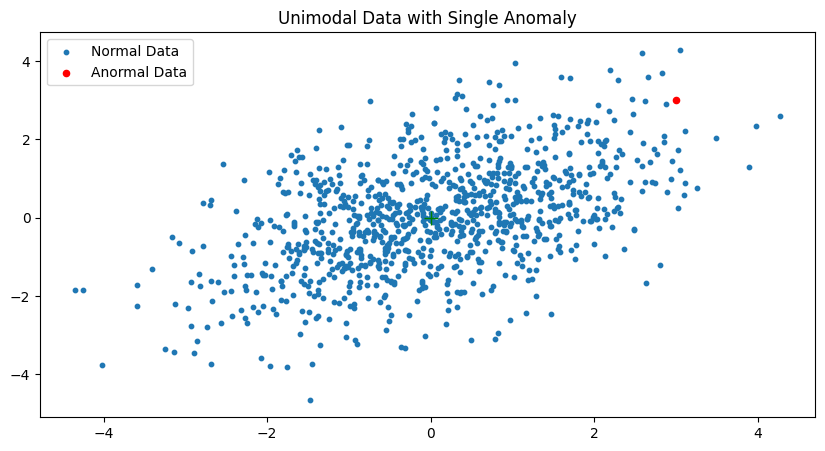

In [7]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.scatter(normal[:, 0], normal[:, 1], s = 10, label = 'Normal Data')
ax.plot([0], [0], marker = '+', color = 'green', markersize = 10) # mark the center
ax.scatter(anomaly[:, 0], anomaly[:, 1], s = 20, color = 'red', label = 'Anormal Data') # add anomaly data point

ax.legend()
ax.set_title('Unimodal Data with Single Anomaly');

In [8]:
# concate normal and anomaly together

dataset1 = np.concatenate((normal, anomaly)) # last item is the anomaly
dataset1

array([[-2.44346794, -1.87756019],
       [-2.7832551 ,  0.38584645],
       [-1.59624225, -2.97832189],
       ...,
       [-1.82853826, -1.60447897],
       [ 2.32553395,  0.47154187],
       [ 3.        ,  3.        ]])

In [9]:
len(dataset1)

1001

In [10]:
# create labels: 0 for nomal, 1 for anomaly

label = np.concatenate([(np.zeros(n, )), np.ones(1, )])  # last item is the anomaly
label

array([0., 0., 0., ..., 0., 0., 1.])

In [11]:
len(label)

1001

In [12]:
label.shape

(1001,)

In [13]:
# 3 required parameters
kernel = "rbf"
nu = 0.1
gamma = 1

coef0 = 0 # default value
degree = 3 # default value

clf_oneClassSVM = svm.OneClassSVM(kernel = kernel, nu = nu, gamma = gamma, coef0 = coef0, degree = degree)
clf_oneClassSVM

OneClassSVM(coef0=0, gamma=1, nu=0.1)

In [14]:
# train/fit a model

clf_oneClassSVM.fit(dataset1)

OneClassSVM(coef0=0, gamma=1, nu=0.1)

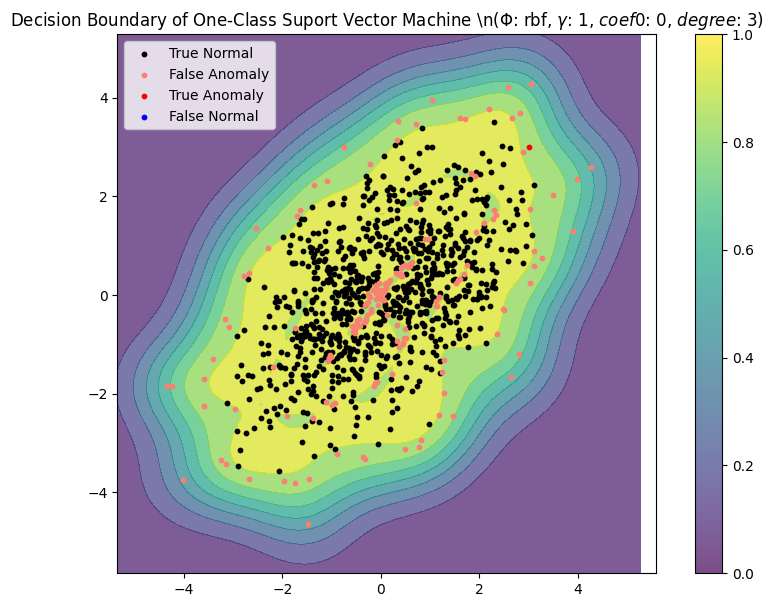

In [15]:
# Decision boundary and anomaly output

dataset = dataset1
normal_data = normal
anomaly_data = anomaly

# plot

fig, ax = plt.subplots(1, 1, figsize = (10, 7)) # make subplot of size 10x5

disp = DecisionBoundaryDisplay.from_estimator(clf_oneClassSVM, # anomaly detector
                                              dataset, # dataset for drawing decision boundary
                                              response_method = "decision_function", # plot decision function
                                              alpha = 0.7, # transparent level
                                              ax = ax)

pred = clf_oneClassSVM.predict(normal_data) # predict 
disp.ax_.scatter(normal_data[pred == 1, 0], normal_data[pred == 1, 1], s = 10, color = 'black', label = "True Normal")
disp.ax_.scatter(normal_data[pred == -1, 0], normal_data[pred == -1, 1], s = 10, color = 'salmon', label = "False Anomaly")

preda = clf_oneClassSVM.predict(anomaly_data) # predict 
disp.ax_.scatter(anomaly_data[preda == -1, 0], anomaly_data[preda == -1, 1], s = 10, color = 'red', label = "True Anomaly")
disp.ax_.scatter(anomaly_data[preda == 1, 0], anomaly_data[preda == 1, 1], s = 10, color = 'blue', label = "False Normal")

disp.ax_.set_title(r"Decision Boundary of One-Class Suport Vector Machine \n($\Phi$: {}, $\gamma$: {}, $coef0$: {}, $degree$: {})".format(kernel, gamma, coef0, degree))
plt.axis("Square")
plt.colorbar(disp.ax_.collections[1])
plt.legend();

In [16]:
# Performance evaluation

pred = clf_oneClassSVM.predict(dataset1)
pred = 1 - ((pred + 1)/2).astype('int') # convert 1 -> 0, -1 -> 1
target_names = ['Nomal', 'Anomaly']

print("Classification Report of Decision Boundary of Local Outlier Factor")
print(classification_report(label, pred, target_names = target_names))

Classification Report of Decision Boundary of Local Outlier Factor
              precision    recall  f1-score   support

       Nomal       1.00      0.84      0.91      1000
     Anomaly       0.01      1.00      0.01         1

    accuracy                           0.84      1001
   macro avg       0.50      0.92      0.46      1001
weighted avg       1.00      0.84      0.91      1001



In [17]:
# Unimodal data surrounded by Anomalies
# create a dataset which the data points are derived from a single multivariate Gaussian population. Oulier are added as the extreme outlier.

np.random.seed(0) # set for consistance run
n = 10_000
n

10000

In [18]:
n_normal = int(n * 0.98)
n_normal

9800

In [19]:
n_anomaly = n - n_normal
n_anomaly

200

In [20]:
normal2, _ = make_blobs(n_samples = n_normal, n_features = 2, centers = [[0, 0]], cluster_std = [1.0])
normal2

array([[ 2.1720921 , -0.14620691],
       [-1.13092728, -0.16036191],
       [-0.76381983,  0.30792253],
       ...,
       [ 0.94327374,  0.30047837],
       [ 0.04968522, -1.60184875],
       [-1.18709247,  0.65935716]])

In [21]:
len(normal2)

9800

In [22]:
# anomalies are located on the circle of radius r = 4 centered at the origin
 
r = 4
theta = np.arange(n_anomaly) * (2 * np.pi * n_anomaly) # 2% anomaly rate
theta

array([     0.        ,   1256.63706144,   2513.27412287,   3769.91118431,
         5026.54824574,   6283.18530718,   7539.82236862,   8796.45943005,
        10053.09649149,  11309.73355292,  12566.37061436,  13823.0076758 ,
        15079.64473723,  16336.28179867,  17592.9188601 ,  18849.55592154,
        20106.19298297,  21362.83004441,  22619.46710585,  23876.10416728,
        25132.74122872,  26389.37829015,  27646.01535159,  28902.65241303,
        30159.28947446,  31415.9265359 ,  32672.56359733,  33929.20065877,
        35185.83772021,  36442.47478164,  37699.11184308,  38955.74890451,
        40212.38596595,  41469.02302739,  42725.66008882,  43982.29715026,
        45238.93421169,  46495.57127313,  47752.20833456,  49008.845396  ,
        50265.48245744,  51522.11951887,  52778.75658031,  54035.39364174,
        55292.03070318,  56548.66776462,  57805.30482605,  59061.94188749,
        60318.57894892,  61575.21601036,  62831.8530718 ,  64088.49013323,
        65345.12719467,  

In [23]:
len(theta), type(theta)

(200, numpy.ndarray)

In [24]:
x = np.cos(theta) * r + np.random.randn(n_anomaly) * r * 0.1
x

array([4.13824916, 3.86209803, 3.91090796, 3.15698466, 3.48906472,
       3.98200253, 4.49630777, 3.78520134, 3.75997755, 3.94043495,
       3.64156799, 3.68919321, 3.86324671, 4.03288218, 3.86461181,
       3.57331502, 4.20043556, 4.36841824, 3.97690262, 3.71805384,
       4.51583389, 4.05435159, 3.8484569 , 3.66020798, 4.44906376,
       4.31800552, 4.24419883, 4.21461297, 3.92152417, 3.52482017,
       3.53205322, 3.77134917, 4.26828343, 4.09751009, 3.22297486,
       4.38929806, 4.02417454, 3.57583833, 4.40610443, 3.58453322,
       4.52878889, 4.07839154, 3.67697688, 3.42537398, 4.7922005 ,
       3.7081905 , 4.40763529, 3.07682376, 4.52112761, 3.85696596,
       4.07350707, 3.8835773 , 4.38965104, 4.33158797, 4.11820714,
       4.03774096, 3.55711867, 3.68175037, 3.62237363, 4.15689317,
       3.6257309 , 4.02811074, 3.48329757, 4.003898  , 3.64754184,
       4.38115689, 3.97226408, 3.63172419, 4.33083697, 4.4628217 ,
       4.15928518, 4.43082953, 3.71974069, 3.97610658, 4.13131

In [25]:
len(x)

200

In [26]:
y = np.sin(theta) * r + np.random.randn(n_anomaly) * r * 0.1
y

array([-0.7484382 , -0.06345132, -0.0324438 , -0.38272528, -0.23739723,
        0.6504494 , -0.11917175,  0.05130609,  0.38713665,  0.12574708,
       -0.110413  ,  0.10834949,  0.08734993,  0.1984614 , -0.03478346,
        0.65298901, -0.6562069 , -1.18765655,  0.53401657,  0.34781761,
       -0.076691  ,  0.16932873,  0.95066974, -0.27267265, -0.56449135,
       -0.56489535, -0.31702201, -0.05400069, -0.53660312, -0.32749463,
       -0.47702724, -0.01844818, -0.02428687,  0.10261947,  0.07018698,
        0.52185801, -0.48134485, -0.65163092,  0.05181227, -0.12425454,
       -0.17290319,  0.56461834, -0.0099415 ,  0.19555729,  0.58928546,
       -0.37058196, -0.23489665, -0.09319964,  0.67289334, -0.8022579 ,
        0.47374182, -0.06368523,  0.38707474, -1.05389026,  0.44764915,
        0.1599077 ,  0.85317581,  0.42061626, -0.25958429, -0.06026753,
       -0.0089972 , -0.39973904, -0.32199238,  0.40928928,  0.00688129,
       -0.22244326, -1.05574711,  0.47097882, -1.02697921,  0.34

In [27]:
len(y)

200

In [28]:
anomaly2 = np.stack((x, y), axis = 0)
anomaly2

array([[ 4.13824916e+00,  3.86209803e+00,  3.91090796e+00,
         3.15698466e+00,  3.48906472e+00,  3.98200253e+00,
         4.49630777e+00,  3.78520134e+00,  3.75997755e+00,
         3.94043495e+00,  3.64156799e+00,  3.68919321e+00,
         3.86324671e+00,  4.03288218e+00,  3.86461181e+00,
         3.57331502e+00,  4.20043556e+00,  4.36841824e+00,
         3.97690262e+00,  3.71805384e+00,  4.51583389e+00,
         4.05435159e+00,  3.84845690e+00,  3.66020798e+00,
         4.44906376e+00,  4.31800552e+00,  4.24419883e+00,
         4.21461297e+00,  3.92152417e+00,  3.52482017e+00,
         3.53205322e+00,  3.77134917e+00,  4.26828343e+00,
         4.09751009e+00,  3.22297486e+00,  4.38929806e+00,
         4.02417454e+00,  3.57583833e+00,  4.40610443e+00,
         3.58453322e+00,  4.52878889e+00,  4.07839154e+00,
         3.67697688e+00,  3.42537398e+00,  4.79220050e+00,
         3.70819050e+00,  4.40763529e+00,  3.07682376e+00,
         4.52112761e+00,  3.85696596e+00,  4.07350707e+0

In [29]:
len(anomaly2)

2

In [30]:
anomaly2.shape

(2, 200)

In [31]:
anomaly2 = np.stack((x, y), axis = 0).T
anomaly2

array([[ 4.13824916e+00, -7.48438196e-01],
       [ 3.86209803e+00, -6.34513221e-02],
       [ 3.91090796e+00, -3.24437993e-02],
       [ 3.15698466e+00, -3.82725275e-01],
       [ 3.48906472e+00, -2.37397226e-01],
       [ 3.98200253e+00,  6.50449400e-01],
       [ 4.49630777e+00, -1.19171750e-01],
       [ 3.78520134e+00,  5.13060913e-02],
       [ 3.75997755e+00,  3.87136651e-01],
       [ 3.94043495e+00,  1.25747077e-01],
       [ 3.64156799e+00, -1.10413001e-01],
       [ 3.68919321e+00,  1.08349488e-01],
       [ 3.86324671e+00,  8.73499315e-02],
       [ 4.03288218e+00,  1.98461405e-01],
       [ 3.86461181e+00, -3.47834627e-02],
       [ 3.57331502e+00,  6.52989012e-01],
       [ 4.20043556e+00, -6.56206898e-01],
       [ 4.36841824e+00, -1.18765655e+00],
       [ 3.97690262e+00,  5.34016570e-01],
       [ 3.71805384e+00,  3.47817609e-01],
       [ 4.51583389e+00, -7.66910040e-02],
       [ 4.05435159e+00,  1.69328725e-01],
       [ 3.84845690e+00,  9.50669739e-01],
       [ 3.

In [32]:
len(anomaly2)

200

In [33]:
anomaly2.shape

(200, 2)

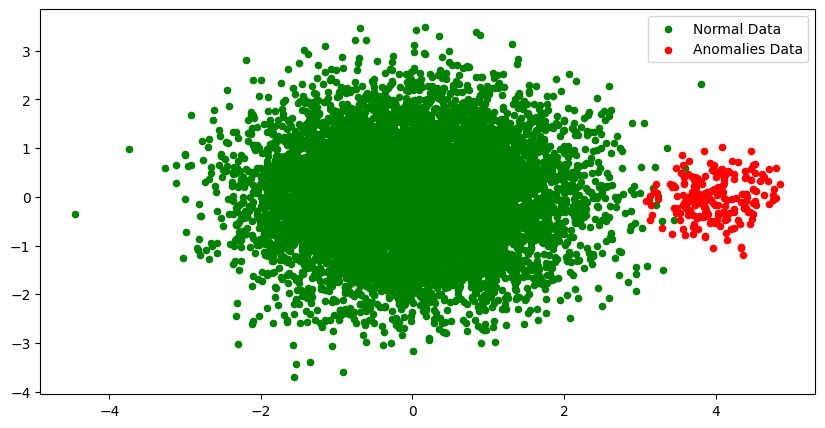

In [34]:
# plot

plt.figure(figsize = (10, 5))
plt.scatter(normal2[:, 0], normal2[:, 1], s = 20, color = 'green', label = 'Normal Data')
plt.scatter(anomaly2[:, 0], anomaly2[:, 1], s = 20, color = 'red', label = 'Anomalies Data')
plt.legend();

In [35]:
# concate nomal and anomalies data

dataset2 = np.concatenate((normal2, anomaly2))
dataset2

array([[ 2.1720921 , -0.14620691],
       [-1.13092728, -0.16036191],
       [-0.76381983,  0.30792253],
       ...,
       [ 4.48989903,  0.16155138],
       [ 3.48682331,  0.01510058],
       [ 3.87422017, -0.26189921]])

In [36]:
len(dataset2)

10000

In [37]:
label2 = np.concatenate([(np.zeros(n_normal, )), np.ones(n_anomaly, )]) # labeled data by setting 0 for normal and 1 for anomaly
label2

array([0., 0., 0., ..., 1., 1., 1.])

In [38]:
len(label2)

10000

In [39]:
label2.shape

(10000,)

In [40]:
# 3 required parameters
kernel = "rbf"
nu = 0.01
gamma = 0.1

coef0 = 0 # default value
degree = 3 # default value

clf_oneClassSVM = svm.OneClassSVM(kernel = kernel, nu = nu, gamma = gamma, coef0 = coef0, degree = degree)
clf_oneClassSVM

OneClassSVM(coef0=0, gamma=0.1, nu=0.01)

In [41]:
# train/fit a model

clf_oneClassSVM.fit(dataset1)

OneClassSVM(coef0=0, gamma=0.1, nu=0.01)

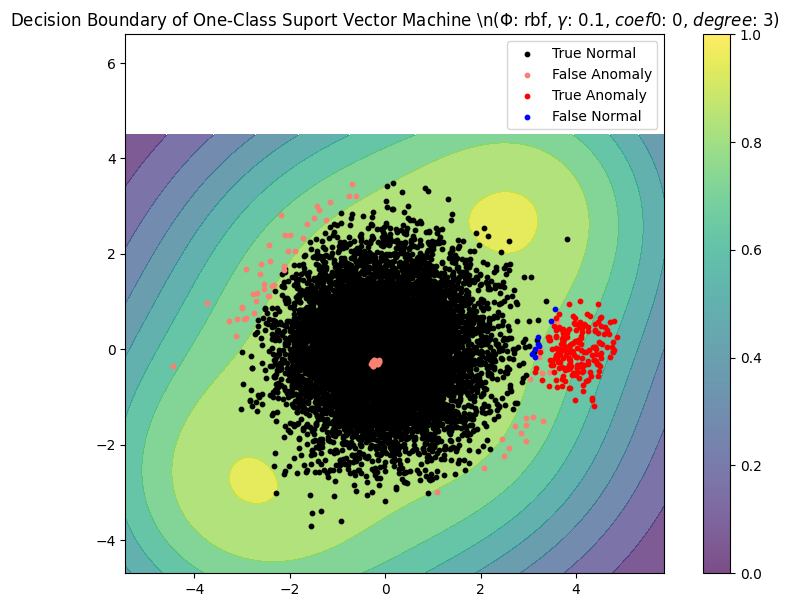

In [42]:
# Decision boundary and anomaly output

dataset = dataset2
normal_data = normal2
anomaly_data = anomaly2

# plot

fig, ax = plt.subplots(1, 1, figsize = (10, 7)) # make subplot of size 10x5

disp = DecisionBoundaryDisplay.from_estimator(clf_oneClassSVM, # anomaly detector
                                              dataset, # dataset for drawing decision boundary
                                              response_method = "decision_function", # plot decision function
                                              alpha = 0.7, # transparent level
                                              ax = ax)

pred = clf_oneClassSVM.predict(normal_data) # predict 
disp.ax_.scatter(normal_data[pred == 1, 0], normal_data[pred == 1, 1], s = 10, color = 'black', label = "True Normal")
disp.ax_.scatter(normal_data[pred == -1, 0], normal_data[pred == -1, 1], s = 10, color = 'salmon', label = "False Anomaly")

preda = clf_oneClassSVM.predict(anomaly_data) # predict 
disp.ax_.scatter(anomaly_data[preda == -1, 0], anomaly_data[preda == -1, 1], s = 10, color = 'red', label = "True Anomaly")
disp.ax_.scatter(anomaly_data[preda == 1, 0], anomaly_data[preda == 1, 1], s = 10, color = 'blue', label = "False Normal")

disp.ax_.set_title(r"Decision Boundary of One-Class Suport Vector Machine \n($\Phi$: {}, $\gamma$: {}, $coef0$: {}, $degree$: {})".format(kernel, gamma, coef0, degree))
plt.axis("Square")
plt.colorbar(disp.ax_.collections[1])
plt.legend();

In [43]:
# Performance evaluation

pred = clf_oneClassSVM.predict(dataset2)
pred = 1 - ((pred + 1)/2).astype('int') # convert 1 -> 0, -1 -> 1
target_names = ['Nomal', 'Anomaly']

print("Classification Report of One-Class Suport Vector Machine")
print(classification_report(label2, pred, target_names = target_names))

Classification Report of One-Class Suport Vector Machine
              precision    recall  f1-score   support

       Nomal       1.00      0.99      1.00      9800
     Anomaly       0.69      0.96      0.80       200

    accuracy                           0.99     10000
   macro avg       0.84      0.98      0.90     10000
weighted avg       0.99      0.99      0.99     10000



In [44]:
# ROC

scores = -clf_oneClassSVM.decision_function(dataset2)
scores

array([-0.11321656, -0.03399391, -0.03439532, ...,  0.444228  ,
        0.06756404,  0.23899294])

In [45]:
len(scores)

10000

In [46]:
fpr, tpr, _ = roc_curve(y_true = label2, y_score = scores, pos_label = 1)
fpr

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.02040816e-04,
       1.02040816e-04, 2.04081633e-04, 2.04081633e-04, 3.06122449e-04,
       3.06122449e-04, 4.08163265e-04, 4.08163265e-04, 5.10204082e-04,
       5.10204082e-04, 6.12244898e-04, 6.12244898e-04, 7.14285714e-04,
       7.14285714e-04, 8.16326531e-04, 8.16326531e-04, 9.18367347e-04,
       9.18367347e-04, 1.12244898e-03, 1.12244898e-03, 1.22448980e-03,
       1.22448980e-03, 1.32653061e-03, 1.32653061e-03, 1.53061224e-03,
       1.53061224e-03, 1.73469388e-03, 1.73469388e-03, 2.14285714e-03,
       2.14285714e-03, 2.24489796e-03, 2.24489796e-03, 2.34693878e-03,
       2.34693878e-03, 2.65306122e-03, 2.65306122e-03, 2.75510204e-03,
       2.75510204e-03, 2.95918367e-03, 2.95918367e-03, 3.36734694e-03,
       3.36734694e-03, 3.77551020e-03, 3.77551020e-03, 3.87755102e-03,
       3.87755102e-03, 3.97959184e-03, 3.97959184e-03, 4.28571429e-03,
       4.28571429e-03, 4.38775510e-03, 4.38775510e-03, 4.59183673e-03,
      

In [47]:
tpr

array([0.   , 0.005, 0.25 , 0.25 , 0.275, 0.275, 0.385, 0.385, 0.52 ,
       0.52 , 0.61 , 0.61 , 0.65 , 0.65 , 0.69 , 0.69 , 0.715, 0.715,
       0.73 , 0.73 , 0.74 , 0.74 , 0.75 , 0.75 , 0.81 , 0.81 , 0.835,
       0.835, 0.84 , 0.84 , 0.845, 0.845, 0.85 , 0.85 , 0.865, 0.865,
       0.87 , 0.87 , 0.875, 0.875, 0.88 , 0.88 , 0.89 , 0.89 , 0.895,
       0.895, 0.9  , 0.9  , 0.905, 0.905, 0.91 , 0.91 , 0.915, 0.915,
       0.925, 0.925, 0.93 , 0.93 , 0.945, 0.945, 0.95 , 0.95 , 0.955,
       0.955, 0.96 , 0.96 , 0.965, 0.965, 0.97 , 0.97 , 0.975, 0.975,
       0.98 , 0.98 , 0.985, 0.985, 0.99 , 0.99 , 0.995, 0.995, 1.   ,
       1.   ])

In [48]:
_

array([ 1.63857563,  0.63857563,  0.3797661 ,  0.37921163,  0.35785333,
        0.35698557,  0.28527349,  0.27746138,  0.22222429,  0.22092975,
        0.19982641,  0.19642064,  0.18390228,  0.17732074,  0.15039891,
        0.14766134,  0.14044701,  0.13952427,  0.13846489,  0.13688581,
        0.13335527,  0.13210273,  0.13092764,  0.13022123,  0.1150486 ,
        0.11473074,  0.10993624,  0.1065225 ,  0.10504704,  0.10383211,
        0.10291957,  0.09771216,  0.09733168,  0.09635426,  0.08877732,
        0.08791845,  0.08433053,  0.07964737,  0.07862302,  0.07383685,
        0.07289322,  0.07109446,  0.06618475,  0.06401635,  0.06369075,
        0.05257605,  0.05047378,  0.04930224,  0.04633678,  0.04230464,
        0.04191629,  0.03838835,  0.03760804,  0.03191537,  0.02561526,
        0.02524784,  0.02197254,  0.02191593,  0.0159043 ,  0.01522259,
        0.01453557,  0.01127742,  0.01054891,  0.00971657,  0.00756762,
       -0.00273267, -0.00274382, -0.00662611, -0.00664236, -0.00

In [49]:
auc_score = auc(fpr, tpr)
auc_score

0.9925397959183673

[]

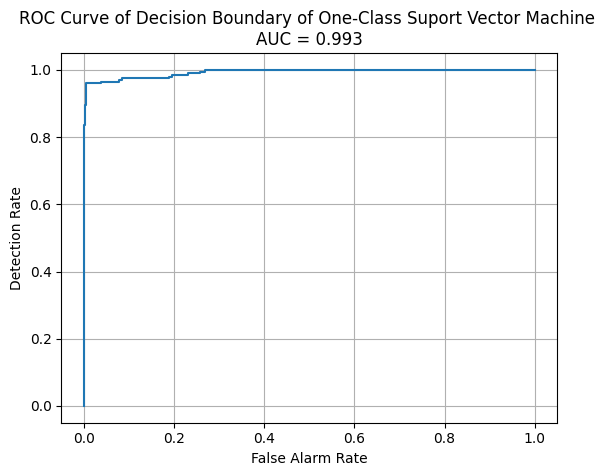

In [50]:
plt.plot(fpr, tpr)
plt.title(f"ROC Curve of Decision Boundary of One-Class Suport Vector Machine \nAUC = {auc_score:0.3f}")
plt.grid()
plt.xlabel("False Alarm Rate")
plt.ylabel("Detection Rate")
plt.plot()